Objective : To check if transfer learning can be used to  improve the model accuracy for marble quality classification.  
Pre trained model used : VGG16  

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [2]:
batch_size = 32
img_height = 224
img_width = 224
train_dir = '../input/marble-surface-anomaly-detection-2/dataset/train'
test_dir = '../input/marble-surface-anomaly-detection-2/dataset/test'

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=323, 
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2249 files belonging to 4 classes.
Using 1800 files for training.


2022-01-24 14:23:52.717446: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-24 14:23:52.847820: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-24 14:23:52.848654: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-24 14:23:52.850941: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=323,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2249 files belonging to 4 classes.
Using 449 files for validation.


In [5]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 688 files belonging to 4 classes.


In [6]:
class_names = train_ds.class_names
print(class_names)

['crack', 'dot', 'good', 'joint']


2022-01-24 13:14:57.696346: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


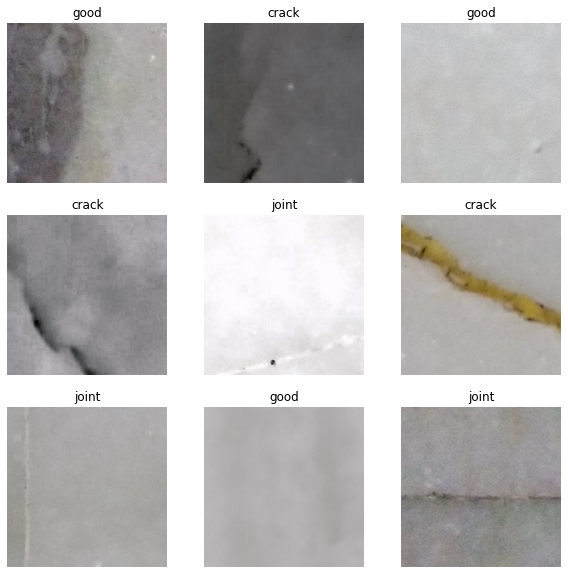

In [7]:
## Visualize train dataset images 

image_batch, label_batch = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    name = class_names[label]
    plt.title(name)
    plt.axis("off")

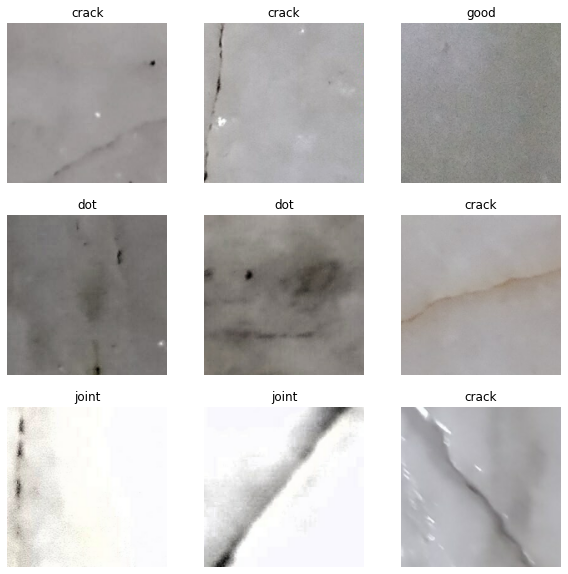

In [8]:
## visualize validation images 
image_batch, label_batch = next(iter(val_ds))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    name = class_names[label]
    plt.title(name)
    plt.axis("off")

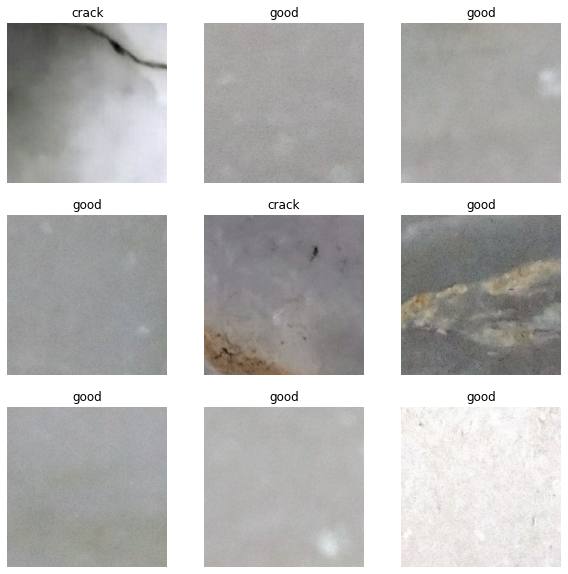

In [9]:
## visualize test images 
image_batch, label_batch = next(iter(test_ds))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    name = class_names[label]
    plt.title(name)
    plt.axis("off")

Check the number of classes in the train , validation and test images.

In [9]:

labels = np.array([])
for x, y in train_ds:
    labels = np.concatenate([labels , y.numpy()])
    
print("Train labels \n{} ".format(pd.Series(labels).value_counts()))

Train labels 
0.0    781
2.0    688
3.0    258
1.0     73
dtype: int64 


In [11]:
labels = np.array([])
for x, y in val_ds:
    labels = np.concatenate([labels , y.numpy()])
print("Validation labels \n{} ".format(pd.Series(labels).value_counts()))

Validation labels 
0.0    203
2.0    172
3.0     55
1.0     19
dtype: int64 


In [12]:
labels = np.array([])
for x, y in test_ds:
    labels = np.concatenate([labels , y.numpy()])
print("Test labels \n{} ".format(pd.Series(labels).value_counts()))

Test labels 
2.0    340
0.0    246
3.0     78
1.0     24
dtype: int64 


The distribution of classes in the train and valdation data is nearly the same. More 'crack' cases followed by 'good' , 'joint' and 'dot.  
How ever in the test data, 'good' cases more than 'crack'.  

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 4100      
Total params: 15,244,100
Trainable params: 529,412
Non-trainable params: 14,714,688
_________________________________________________________________
CPU times: user 3min 28s, sys: 22.6 s, total: 3min 51s
Wall time: 6min 45s
22/22 [==============================] - 2s 67ms/step - loss: 0.4218 - accuracy: 0.9666
Test image accuracy :0.9665697813034058
              precision    recall  f1-score   support

       crack       0.96      0.98      0.97       246
         dot       0.80      0.83      0.82        24


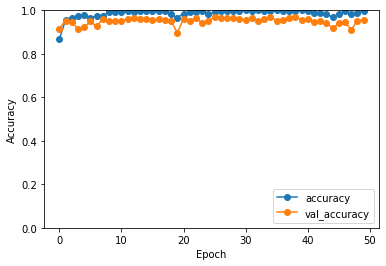

In [19]:
# Transfer learning with VGG16 . 

base_Net = tf.keras.applications.VGG16(include_top = False, 
                         weights ='imagenet', 
                         input_shape = (224,224,3), 
                         pooling='avg',
                         )

base_Net.trainable = False
#Adding the final layers to the above base models where the actual classification is done in the dense layers

model_Net = tf.keras.models.Sequential()
model_Net.add(base_Net)
model_Net.add(tf.keras.layers.Dense(1024))
model_Net.add(tf.keras.layers.Dense(4, activation=tf.nn.softmax))

model_Net.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model_Net.summary()

# Training the CNN on the Train data and evaluating it on the val data
%time history = model_Net.fit(train_ds , validation_data = val_ds, epochs = 50, verbose = 0 )

##
test_loss, test_acc = model_Net.evaluate(test_ds)
print("Test image accuracy :{}".format(test_acc))
##
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
##
model_Net.save('vgg16')
##

test_pred = np.array([])
test_labels = np.array([])
for x, y in test_ds:
    
    predictions =  np.argmax(model_Net.predict(x), axis = -1)
    test_pred = np.concatenate([test_pred,np.array(predictions)])
    test_labels = np.concatenate([test_labels , y.numpy()])
    
## classification report 
print(classification_report(test_labels, test_pred, target_names = class_names))

It's seen that using transfer learning , very good accuracy of 0.97 is achieved.  